In [30]:
import random
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
# from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for apple silicon (mps much slower than cpu)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Files already downloaded and verified
torch.Size([224, 224, 3])


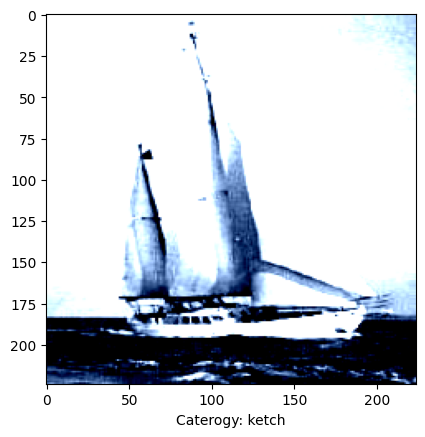

In [17]:
# load dataset

path_to_dataset = Path(os.getcwd()) / "dataset"
path_to_dataset.mkdir(exist_ok=True)

def grayscale_to_rgb(image):
    if image.shape == torch.Size([3, 224, 224]):
      return image
    return torch.cat([image, image, image], dim=0)
  
transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    grayscale_to_rgb,
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

  ]
)

data = datasets.Caltech101(root=path_to_dataset, 
                           download=True, 
                           transform=transforms)


idx = random.randint(0, data.__len__()-1)
mapping = {i:j for i, j in enumerate(data.categories)} 
plt.imshow(data[idx][0].permute(1, 2, 0))
plt.xlabel(f"Caterogy: {mapping.get(data[idx][1])}");
print(data[idx][0].permute(1, 2, 0).shape)

torch.Size([32, 32, 1])
Categories 10


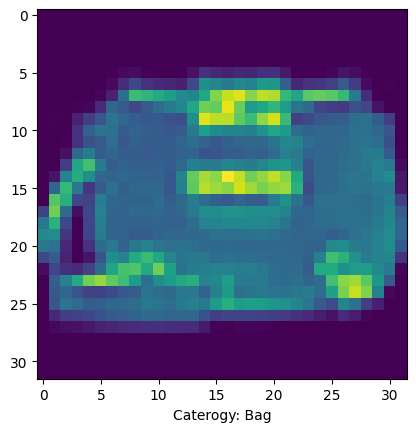

In [18]:
#fashion mnist dataset
path_to_dataset = Path(os.getcwd()) / "dataset"
path_to_dataset.mkdir(exist_ok=True)

transforms = Compose([
    Resize((32, 32)),
    ToTensor(),
    # grayscale_to_rgb,
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

  ]
)

data = datasets.FashionMNIST(root=path_to_dataset,
                             download=True,
                             transform=transforms)

idx = random.randint(0, data.__len__()-1)
mapping = {i:j for i, j in enumerate(data.classes)} 
plt.imshow(data[idx][0].permute(1, 2, 0))
plt.xlabel(f"Caterogy: {mapping.get(data[idx][1])}");
print(data[idx][0].permute(1, 2, 0).shape)
print(f"Categories {len(data.classes)}")

In [19]:
_train_data, _test_data = torch.utils.data.random_split(data, [.8, .2])
        
train_data = DataLoader(_train_data, batch_size=4, shuffle=True)
test_data = DataLoader(_test_data, batch_size=4, shuffle=True)

del _train_data
del _test_data

In [20]:
class VGG11(nn.Module):
  def __init__(self, input_channels, out_channels):
    super(VGG11, self).__init__()
    inplace = True
    num_classes = 101
    pool_kernel_size = (2, 2)
    conv_kernel_size = (3, 3)

    self.conv = nn.Sequential(
      nn.Conv2d(input_channels, out_channels, kernel_size=conv_kernel_size, padding=1),
      nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=inplace),

      nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=inplace),

      nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=inplace),
      nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=inplace),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),

      nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=inplace),
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=inplace),

      nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=inplace),
      nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=inplace),
    )

    self.avg_pool = nn.AdaptiveAvgPool2d((7, 7))
     
    self.linear = nn.Sequential(
      nn.Linear(512*7*7, 4096),
      nn.ReLU(inplace=inplace),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=inplace),
      nn.Dropout(0.5),
      nn.Linear(4096, num_classes),
      nn.ReLU(inplace=inplace),
      # nn.LogSoftmax(dim=1)
      nn.Softmax(dim=1)
    )
    
    self._init_layer()

    
    
  def forward(self, x):
    x = self.conv(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.linear(x)
    return x
  
  def _init_layer(self):
    for layer in self.linear:
      if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, 0, 0.01)
        nn.init.constant_(layer.bias, 0)

In [27]:
INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 64
vgg = VGG11(INPUT_CHANNELS, OUTPUT_CHANNELS).to(device)

total_params = sum(p.numel() for p in vgg.parameters())
print(f"[INFO]: {total_params:,} total parameters.")

lr = 1e-2
# optimizer = optim.SGD(vgg.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(vgg.parameters(), lr=lr)
# loss_function = nn.NLLLoss()
# loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()

EPOCHS = 2

for epoch in (t:=trange(EPOCHS)):
  running_loss = 0.0
  for i, data in enumerate(train_data, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)

    optimizer.zero_grad()
    
    # with torch.autograd.set_detect_anomaly(True):
    outputs = vgg(inputs)
    # logits = F.softmax(outputs, dim=1)
    logits = outputs
    
    loss = loss_function(logits, labels)
    loss.backward()
    optimizer.step()

      # SummaryWriter().add_histogram('intermediate_activations', x, global_step=epoch)
      
    running_loss += loss.item()
  
    loss.item()
    
    t.set_description(f"Running loss {(loss.item()):.4f}")

    # break
    



[INFO]: 129,184,485 total parameters.


Running loss 4.6320:   0%|          | 0/2 [00:31<?, ?it/s]


KeyboardInterrupt: 